# MNA - Master in Applied Artificial Intelligence
## Course: Fintech and Digital Innovation in Finance
### Course project part 1
#### Text embeddings and Technical Analysis on S&P 500 data (Section A)

---

**Student:** Emiliano Saucedo Arriola | A01659258  

**Date:** July 28th, 2025

---

# Introduction to text embeddings on S&P 500 news

## 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [1]:
!pip -q install pandas yfinance lxml -U sentence-transformers tqdm matplotlib

In [2]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf
import numpy as np

/Users/emisaar/Documents/MNA/Verano/fintech/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get the list of stocks in the S&P 500 

In [3]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
ticker_list = df_tickers['Symbol'].tolist()
print(f"Sample tickers: {ticker_list[:5]}")

Sample tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN']


## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [5]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks 
# and the value is the output news from the yfinance library

from tqdm import tqdm
import random
import time

# Create a dictionary to store the news for each stock
news_dict = {}

# Loop through all tickers in the S&P 500
for ticker in tqdm(ticker_list, desc="Fetching news"):
    try:
        stock = yf.Ticker(ticker)
        news = stock.news
        news_dict[ticker] = news
        time.sleep(random.uniform(0.1, 0.2))
    except Exception as e:
        print(f"Error fetching news for {ticker}: {e}")
        news_dict[ticker] = []

Fetching news: 100%|██████████| 503/503 [02:56<00:00,  2.84it/s]


In [6]:
# Quick inspection of the news data structure
def print_schema(obj, indent=0):
    prefix = "  " * indent
    if isinstance(obj, dict):
        for key, value in obj.items():
            print(f"{prefix}{key}: {type(value).__name__}")
            print_schema(value, indent + 1)
    elif isinstance(obj, list) and obj:
        print(f"{prefix}[List of {type(obj[0]).__name__}]")
        print_schema(obj[0], indent + 1)

for ticker, news_list in news_dict.items():
    if news_list:
        print(f"\nSchema for first news in ticker: {ticker}")
        print_schema(news_list[0])
        break



Schema for first news in ticker: MMM
id: str
content: dict
  id: str
  contentType: str
  title: str
  description: str
  summary: str
  pubDate: str
  displayTime: str
  isHosted: bool
  bypassModal: bool
  previewUrl: NoneType
  thumbnail: dict
    originalUrl: str
    originalWidth: int
    originalHeight: int
    caption: str
    resolutions: list
      [List of dict]
        url: str
        width: int
        height: int
        tag: str
  provider: dict
    displayName: str
    url: str
  canonicalUrl: dict
    url: str
    site: str
    region: str
    lang: str
  clickThroughUrl: dict
    url: str
    site: str
    region: str
    lang: str
  metadata: dict
    editorsPick: bool
  finance: dict
    premiumFinance: dict
      isPremiumNews: bool
      isPremiumFreeNews: bool
  storyline: NoneType


### Structure the news into a pandas dataframe 

Your final dataframe should have the following columns: 
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [7]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Initialize a list to store structured news data
news_data = []

# Iterate through the news dictionary
for ticker, news_items in news_dict.items():
    for article in news_items:
        # Extract fields
        content = article.get('content', {})
        if isinstance(content, dict) and content:
            news_data.append(
                {
                    "TICKER": ticker,
                    "TITLE": content.get('title', None),
                    "SUMMARY": content.get('summary', None),
                    "PUBLICATION_DATE": pd.to_datetime(content.get('pubDate', None)),
                    "URL": content.get('canonicalUrl', {}).get('url', None)
                }
            )

In [8]:
# Create the DataFrame
df_news = pd.DataFrame(news_data)

# Show the shape and first few rows
display(df_news.head(5))

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21 09:45:00+00:00,https://finance.yahoo.com/news/zacks-industry-...
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21 08:22:00+00:00,https://finance.yahoo.com/news/stock-market-ne...
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19 07:05:47+00:00,https://finance.yahoo.com/news/3m-co-mmm-q2-20...
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19 05:30:58+00:00,https://finance.yahoo.com/news/mmm-q1-deep-div...


In [9]:
# Brief summary
print("Missing values in the DataFrame:")
print("   TICKER:", df_news['TICKER'].isna().sum())
print("   TITLE:", df_news['TITLE'].isna().sum())
print("   SUMMARY:", df_news['SUMMARY'].isna().sum())
print("   PUBLICATION_DATE:", df_news['PUBLICATION_DATE'].isna().sum())
print("   URL:", df_news['URL'].isna().sum())
print("   Total missing values:", df_news.isna().sum().sum())
print("--" * 50)
print("Total number of articles:", df_news.shape[0])

Missing values in the DataFrame:
   TICKER: 0
   TITLE: 0
   SUMMARY: 0
   PUBLICATION_DATE: 0
   URL: 0
   Total missing values: 0
----------------------------------------------------------------------------------------------------
Total number of articles: 5020


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [10]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Load the pre-trained embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Add a column called 'EMBEDDED_TEXT'
df_news['EMBEDDED_TEXT'] = df_news['TITLE']

# Add a column called 'EMBEDDINGS'
embeddings = model.encode(df_news['EMBEDDED_TEXT'].tolist(), show_progress_bar=True)

# Assign to new column
df_news['EMBEDDINGS'] = embeddings.tolist()

Batches: 100%|██████████| 157/157 [00:05<00:00, 27.34it/s]


In [11]:
# Display the updated dataframe
display(df_news[['TICKER', 'EMBEDDED_TEXT', 'EMBEDDINGS']].head())

,TICKER,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455369293689728, -0.10904759913682938, -..."
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.021629296243190765, -0.07978318631649017, ..."
2,MMM,"Stock Market News for Jul 21, 2025","[-0.03746957331895828, -0.04381373152136803, 0..."
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,"[-0.08080148696899414, -0.02980072610080242, -..."
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,"[-0.019502609968185425, -0.07280398905277252, ..."


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [12]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Keep only the first occurrence of each ticker
df_news_500 = df_news.sort_values(by='PUBLICATION_DATE', ascending=False).drop_duplicates(subset='TICKER', keep='first')

# Ensure there are exactly 500
df_news_500 = df_news_500.head(500)
print(f"Number of unique tickers: {df_news_500.shape[0]}")
display(df_news_500.head())

Number of unique tickers: 500


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
3670,PFE,Pfizer (PFE) Receives CHMP Recommendation For ...,BioNTech SE and Pfizer (PFE) recently received...,2025-07-26 17:12:59+00:00,https://finance.yahoo.com/news/pfizer-pfe-rece...,Pfizer (PFE) Receives CHMP Recommendation For ...,"[-0.017735008150339127, -0.01245556864887476, ..."
4550,UBER,Is Now a Good Time To Invest in Uber? Here’s W...,Uber stock is up substantially in 2025 due to ...,2025-07-26 17:02:06+00:00,https://finance.yahoo.com/news/now-good-time-i...,Is Now a Good Time To Invest in Uber? Here’s W...,"[0.0599096417427063, -0.042135726660490036, -0..."
190,GOOGL,Why Google should 'walk away' from Waymo,Needham & Company senior media and internet an...,2025-07-26 17:00:18+00:00,https://finance.yahoo.com/video/why-google-wal...,Why Google should 'walk away' from Waymo,"[-0.059040844440460205, -0.018665721639990807,..."
200,GOOG,Why Google should 'walk away' from Waymo,Needham & Company senior media and internet an...,2025-07-26 17:00:18+00:00,https://finance.yahoo.com/video/why-google-wal...,Why Google should 'walk away' from Waymo,"[-0.059040844440460205, -0.018665721639990807,..."
460,T,AT&T sounds alarm on why customers are leaving,"AT&T, like many of its competitors, is battlin...",2025-07-26 16:33:00+00:00,https://www.thestreet.com/retail/at-t-sounds-a...,AT&T sounds alarm on why customers are leaving,"[0.051091182976961136, -0.03638583794236183, 0..."


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [13]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Test k from 2 to 6
range_n_clusters = range(2, 7)
silhouette_scores = []

# Create the feature matrix
X = np.array(df_news_500['EMBEDDINGS'].to_list())

for k in range_n_clusters:
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Compute silhouette score
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)
    
    print(f"k = {k} → Silhouette Score = {score:.4f}")

k = 2 → Silhouette Score = 0.0396
k = 3 → Silhouette Score = 0.0440
k = 4 → Silhouette Score = 0.0467
k = 5 → Silhouette Score = 0.0475
k = 6 → Silhouette Score = 0.0480


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Plot silhouette scores

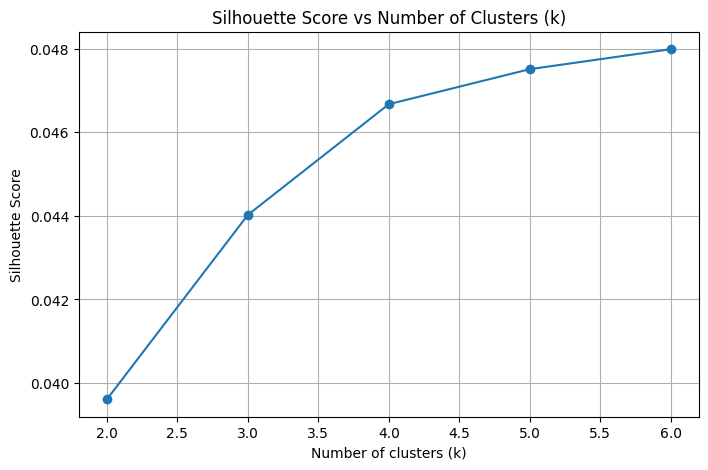

In [14]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#### Identify the Best k

In [15]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

best_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Best k based on silhouette score: {best_k}")

Best k based on silhouette score: 6


#### Cluster the embeddings using 3 clusters (k=3)

In [16]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Run KMeans clustering
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X)

# Add the cluster labels to the DataFrame
df_news_500['CLUSTER'] = cluster_labels

In [17]:
# Show a few sample rows with cluster assignment
display(df_news_500[['TICKER', 'TITLE', 'CLUSTER']].head(10))

,TICKER,TITLE,CLUSTER
3670,PFE,Pfizer (PFE) Receives CHMP Recommendation For ...,2
4550,UBER,Is Now a Good Time To Invest in Uber? Here’s W...,0
190,GOOGL,Why Google should 'walk away' from Waymo,2
200,GOOG,Why Google should 'walk away' from Waymo,2
460,T,AT&T sounds alarm on why customers are leaving,2
3451,NVDA,"After Soaring Nearly 100% So Far This Year, Wh...",0
3581,PLTR,"After Soaring Nearly 100% So Far This Year, Wh...",0
3151,MSFT,The Microsoft Hack Affected Some of the Highes...,0
3640,PYPL,Why you might one day use stablecoins in place...,2
1930,FIS,Why you might one day use stablecoins in place...,2


In [18]:
cluster_counts = df_news_500['CLUSTER'].value_counts().sort_index()
print("Companies per cluster:")
print(cluster_counts)

Companies per cluster:
CLUSTER
0    185
1    161
2    154
Name: count, dtype: int64


### Visualize the 2 first PCA Components of your embeddings

In [19]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Reduce embeddings to 2 dimensions using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Add PCA components to the DataFrame for plotting
df_news_500['PCA1'] = X_pca[:, 0]
df_news_500['PCA2'] = X_pca[:, 1]


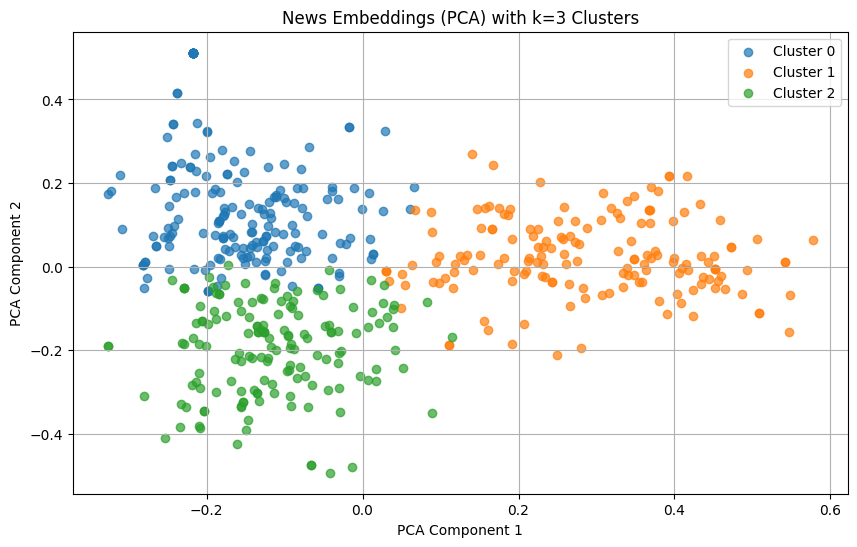

In [20]:
# Scatter plot by cluster
plt.figure(figsize=(10, 6))
for cluster_id in sorted(df_news_500['CLUSTER'].unique()):
    cluster_data = df_news_500[df_news_500['CLUSTER'] == cluster_id]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f"Cluster {cluster_id}", alpha=0.7)

plt.title("News Embeddings (PCA) with k=3 Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [23]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Print 5 sample news headlines per cluster
for cluster_id in sorted(df_news_500['CLUSTER'].unique()):
    print(f"\n=== Cluster {cluster_id} ===")
    
    sample_headlines = (
        df_news_500[df_news_500['CLUSTER'] == cluster_id]['TITLE']
        .drop_duplicates()
        .head(5)
        .tolist()
    )
    
    for i, title in enumerate(sample_headlines, 1):
        print(f"{i}. {title}")


=== Cluster 0 ===
1. Is Now a Good Time To Invest in Uber? Here’s What Experts Say
2. After Soaring Nearly 100% So Far This Year, Where Will Palantir Stock Be at the End of 2025?
3. The Microsoft Hack Affected Some of the Highest Levels of Government. The Stock Is Up.
4. Stock Prices Don't Tell the Story—Here's What Humphrey Yang Says You Should Focus On Instead
5. China, Chips, and Chaos: Where Smart Investors Are Putting Their Money Now

=== Cluster 1 ===
1. Deckers Outdoor (DECK) Soars 11% on Impressive Earnings
2. Healthpeak Properties (DOC) Drops 6.7% on Steep  Q2 Earnings Dive
3. Edwards Lifesciences Second Quarter 2025 Earnings: Revenues Beat Expectations, EPS Lags
4. Amphenol Corporation Just Recorded A 28% EPS Beat: Here's What Analysts Are Forecasting Next
5. Analysts Have Made A Financial Statement On Honeywell International Inc.'s (NASDAQ:HON) Second-Quarter Report

=== Cluster 2 ===
1. Pfizer (PFE) Receives CHMP Recommendation For Adapted COVID-19 Vaccine COMIRNATY
2. Why

In [25]:
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Función para limpiar el texto
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS and len(t) > 2]
    return tokens


# Diccionario para guardar los conteos
cluster_keywords = {}

# Iterar sobre cada clúster
for cluster_id in sorted(df_news_500['CLUSTER'].unique()):
    titles = df_news_500[df_news_500['CLUSTER'] == cluster_id]['TITLE'].drop_duplicates().tolist()
    all_tokens = []
    for title in titles:
        all_tokens.extend(clean_text(title))
    
    # Contar las palabras más comunes
    word_counts = Counter(all_tokens).most_common(10)
    cluster_keywords[cluster_id] = word_counts

# Mostrar resultados
for cluster_id, words in cluster_keywords.items():
    print(f"\nCluster {cluster_id} — Top words:")
    for word, count in words:
        print(f"  {word}: {count}")



Cluster 0 — Top words:
  stock: 69
  stocks: 28
  dividend: 24
  buy: 18
  investors: 16
  market: 13
  know: 12
  earnings: 11
  facts: 8
  heres: 7

Cluster 1 — Top words:
  earnings: 139
  report: 41
  2025: 30
  expect: 26
  beat: 22
  estimates: 21
  stock: 19
  analysts: 14
  whats: 13
  key: 12

Cluster 2 — Top words:
  case: 16
  bull: 15
  theory: 15
  jim: 13
  cramer: 13
  says: 11
  buy: 8
  group: 8
  growth: 8
  rating: 7




## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

> The choice of embedding model affects clustering through a trade-off between semantic depth and efficiency. Larger models capture finer nuances, leading to more coherent and interpretable clusters, while MiniLM offers speed and scalability at the cost of subtle meaning.

Aditional Reviewed Materials:
- https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

> Embeddings from the title capture the main idea quickly, while the summary provides more detail and context. Using both together can produce richer representations and improve clustering results.

---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

> Using dimensionality reduction methods like t-SNE or UMAP is preferable over PCA when the goal is to visualize how similar items group together in complex data. While PCA highlights global variance and linear structure, t-SNE and UMAP are better at preserving local relationships, making them more effective for revealing meaningful clusters in high-dimensional embeddings.

Aditional Reviewed Materials:
- https://distill.pub/2016/misread-tsne/
- https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
- https://www.ibm.com/think/topics/principal-component-analysis

---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

> Interpreting the clusters presented two main challenges. First, the semantic overlap in news content makes it difficult to assign articles to a single, distinct theme. Second, using K-Means imposed rigid cluster boundaries and required a fixed number of clusters, which may not align well with the complex, nuanced structure of language embeddings.  
> To address these issues, enriching the input text with summaries and adopting more flexible clustering methods like HDBSCAN, can lead to clearer, more interpretable groupings.

Additional Reviewed Materials:
- https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

> Yes, the 2D visualization reveals potential outliers appearing as isolated points far from their clusters. In a production pipeline, they can be identified by measuring their distance to cluster centroids or using methods like HDBSCAN that detect noise. These outliers should be handled carefully, as they may distort clustering results or highlight valuable anomalies.

---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

**Cluster 0**
* **Main Theme:** *Investment Opportunities & Stock Insights*
* **Tone/Function:** Informative and advisory; aimed at guiding individual investors with general stock market ideas, dividend strategies, and long-term positioning.
* **Examples:**

  * *Is Now a Good Time To Invest in Uber?*
  * *Where Will Palantir Stock Be at the End of 2025?*
  * Keywords: *stock, dividend, buy, investors, market*

**Cluster 1**
* **Main Theme:** *Earnings Reports & Financial Forecasts*
* **Tone/Function:** Factual and data-driven; focused on recent earnings, financial metrics, analyst estimates, and short-term stock movements.
* **Examples:**

  * *DECK Soars 11% on Impressive Earnings*
  * *EPS Beat: Here's What Analysts Are Forecasting Next*
  * Keywords: *earnings, report, estimates, beat, analysts*

**Cluster 2**
* **Main Theme:** *Market Commentary & Media Opinions*
* **Tone/Function:** Opinionated and narrative-driven; highlights investment cases, media personalities (e.g., Jim Cramer), and speculative or macroeconomic viewpoints.
* **Examples:**

  * *Why Google should ‘walk away’ from Waymo*
  * *‘Vegas is not fun anymore’: Rising prices steer travelers away*
  * Keywords: *case, theory, cramer, says, rating*

Confidence is moderate to high, based on consistency between keywords and sample headlines. However, to validate these labels more systematically, one could apply topic modeling techniques, such as BERTopic, or leverage LLMs to generate cluster summaries.

Additional Reviewed Materials:
- https://medium.com/@danushidk507/topic-modelling-with-bertopic-249095144555

---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

> Incorporating news sentiment would lead to clusters differentiated by both content and emotion, such as "Positive Earnings" or "Negative Corporate News." This creates more actionable financial insights, allowing for strategies driven by both: what the news is and how it's perceived.

---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

> K-Means isn't always the best for news embeddings since it assumes clusters are round and evenly sized, which isn't how text data usually behaves. Methods like DBSCAN or HDBSCAN are better when clusters have weird shapes or different densities. And if the topics overlap or aren’t clearly separated, something like hierarchical or spectral clustering might make more sense.

---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

High-level pipeline:

1. **News Processing**
* Collect S\&P 500 news headlines/summaries.
* Generate embeddings using `all-MiniLM-L6-v2` or other models such as Gemma (it is important to consider vector dimentionality). Create embeddings using the title + summary.
* Cluster the embeddings using KMeans or density-based methods like HDBSCAN to allow for more flexible topic boundaries.

2. **Stock Price Alignment**
* For each article, fetch the related stock’s price based on its ticker and publication date.
* Align each news item with price changes in a short-term window (e.g., 1–3 days after publication).

3. **Label Generation**
* Calculate the percentage change in price after the news window.
* Assign a label to each article — **Positive**, **Negative**, or **Neutral** — based on defined thresholds (e.g., ±0.5%).

4. **Analysis & Insights**
* Visualize the distribution of movement types across clusters using heatmaps or tables.
* Apply statistical tests to evaluate whether certain clusters are significantly associated with specific types of stock movements. For example, we can use chi-squared for label distribution or ANOVA for price changes.

5. **Predictive Modeling**
* Train a model using clusters, sentiment, and embeddings to predict movement labels.
* Evaluate performance against a baseline.
* Analyze which clusters, textual patterns, or sentiment signals contribute most to the model's predictions.

---

#### 🔟 Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

> Even if news clusters appear clear and meaningful, they often don't improve stock prediction. This is because the clusters might group news based on textual similarities that simply aren't relevant to price movements, or the market may have already reacted to the information before it was processed. Essentially, clustering aims to organize data, not predict future outcomes, so its groupings might not align with the actual drivers of stock performance."
